# Self-Explaining Neural Networks
---

## Import libraries

In [31]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from types import SimpleNamespace
from importlib import import_module
import matplotlib.pyplot as plt

%matplotlib inline

In [19]:
from models.losses import mse_l1_sparsity
from models.parameterizer import ConvParameterizer
from models.conceptizer import ConvConceptizer
from models.aggregator import SumAggregator
from models.senn import SENN

## Configuration

In [35]:
plt.style.use('seaborn-talk')

In [20]:
config = {
    "conceptizer": "ConvConceptizer",
    "image_size": 28,
    "concept_dim": 1,
    "concept_visualization": "activation",
    "parameterizer": "ConvParameterizer",
    "cl_sizes": [1, 10, 20],
    "hidden_sizes": [320, 50],
    "num_concepts": 5,
    "num_classes": 10,
    "dropout": 0.5,
    "aggregator": "SumAggregator",
    "device": "cpu",
    "robust_reg": 1e-3,
    "concept_reg": 1,
    "exp_name": "mnist_test",
    "dataloader": "mnist",
    "data_path": "datasets/data/mnist_data",
    "batch_size" : 64,
    "sparsity_reg" : 2e-5,
}
config = SimpleNamespace(**config)

## Load Test Data

In [21]:
from datasets.dataloaders import get_dataloader
_, _, test_dl = get_dataloader(config)

## Load Trained Model

In [ ]:
conceptizer =  ConvConceptizer()

In [22]:
conceptizer = getattr(import_module("models.conceptizer"), config.conceptizer)(**config.__dict__)
parameterizer = getattr(import_module("models.parameterizer"), config.parameterizer)(**config.__dict__)
aggregator = getattr(import_module("models.aggregator"), config.aggregator)(**config.__dict__)

In [23]:
model = SENN(conceptizer, parameterizer, aggregator)

In [24]:
checkpoint_path = Path('results')
model_file = checkpoint_path / config.exp_name / "checkpoints" / "best_model.pt" 
checkpoint = torch.load(model_file, config.device)
print(f"Loading trained model: {model_file}")

Loading trained model: results/mnist_test/checkpoints/best_model.pt


In [25]:
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

## Test Performance

In [26]:
get_nll_Loss = nn.NLLLoss
get_sparsity_loss = mse_l1_sparsity

In [27]:
accuracy = 0.
model.eval()
with torch.no_grad():
    for i, (x, labels) in enumerate(test_dl):
        x = x.float().to(config.device)
        labels = labels.long().to(config.device)
        y_pred, (concepts, relevances), x_reconstructed = model(x)
        accuracy += (y_pred.argmax(axis=1) == labels).float().mean().item()
print(f"Test Mean Accuracy: {accuracy/i*100:.3f} %")

Test Mean Accuracy: 99.042 %


## Result Visualization

In [41]:
def create_barplot(relevances, y_pred, concept_names=None):
    """Creates a bar plot of relevances.

    Parameters
    ----------
    relevances: torch.tensor
       The relevances for which the bar plot should be generated. shape: (1, NUM_CONCEPTS, NUM_CLASSES)
    y_pred: torch.tensor (int)
       The prediction of the model for the corresponding relevances. shape: scalar value
    save_path: str
        Path to the location where the bar plot should be saved.
    """
    fig, ax = plt.subplots(figsize=(2,2))
    
    y_pred = y_pred.item()
    relevances = relevances[0, :, y_pred].squeeze()
    if concept_names is None:
        concept_names = ['Concept {}'.format(i + 1) for i in range(len(relevances))]
        concept_names.reverse()
    y_pos = np.arange(len(concept_names))
    colors = ['b' if r > 0 else 'r' for r in relevances]
    colors.reverse()

    ax.barh(y_pos, np.flip(relevances.detach().cpu().numpy()), align='center', color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(concept_names)
    ax.set_xlabel('Relevances (thetas)')
    ax.set_title('Explanation for prediction: {}'.format(y_pred))
    plt.show()

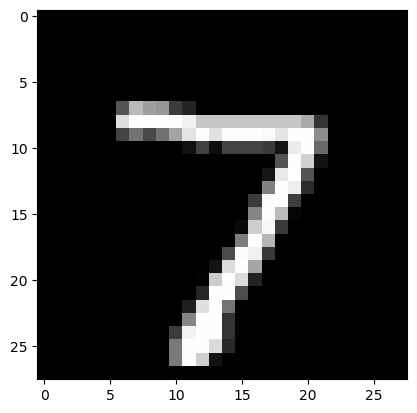

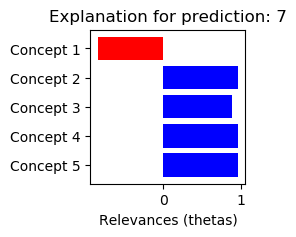

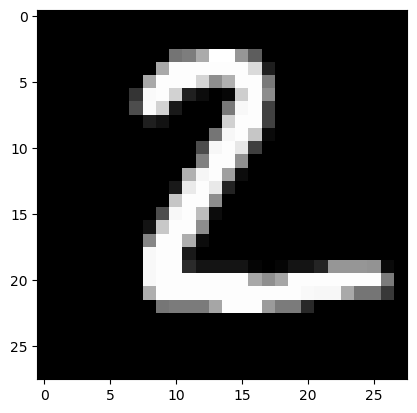

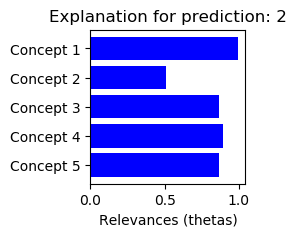

In [47]:
(test_batch, test_labels) = next(iter(test_dl))

for i in range(2):
    example = test_batch[i].float().to(config.device)
    if config.dataloader == 'mnist':
       plt.imshow(example[0], cmap='gray')
    y_pred, (concepts, relevances), _ = model(example.unsqueeze(0))
    if len(y_pred.size()) > 1:
        y_pred = y_pred.argmax(1)
    create_barplot(relevances, y_pred)